In [47]:
import numpy as np
import mne
import pyedflib
import swlda
from pyedflib import highlevel
from datetime import datetime
from mne.decoding import CSP

In [25]:
board = [["A",    "B",  "C",   "D",    "E",    "F",     "G",    "H"],
         ["I",    "J",  "H",   "L",    "M",    "N",     "O",    "P"],
         ["Q",    "R",  "S",   "T",    "U",    "V",     "W",    "X"],
         ["Y",    "Z",  "Sp",  "1",    "2",    "3",     "4",    "5"],
         ["6",    "7",  "8",   "9",    "0",    ".",     "RET",  "BS"],
         ["CTRL", "=",  "DEL", "HOME", "UPAW", "END",   "PGUP", "SHIFT"],
         ["SAVE", "'",  "F2",  "LFAW", "DNAW", "RTAW",  "PGON", "PAUSE"],
         ["CAPS", "F5", "TAB", "EC",   "ESC",  "EMAIL", "!",    "SLEEP"]]


def RCIndexConveter(board, index: int) -> str:
    """
    Convert index on the board to the character.

    Parameters:
        - board (2d list of str): a rectangle board to display characters.
        - index: the index on each location

    Returns:
        the character corresponding to the given index.
    """
    num_rows = len(board)
    num_cols = len(board[0])
    r = (index - 1) // num_cols
    c = (index - 1) %  num_cols
    return board[r][c]

In [4]:
filename = '../data/RC/A01_SE001RC_Train01.edf'
raw_data = mne.io.read_raw_edf(filename, verbose=False) # read data
raw_data.load_data() # load data
eeg_channels = mne.pick_channels_regexp(raw_data.info['ch_names'], 'EEG')
raw_data.notch_filter(freqs=60, picks=eeg_channels)

Reading 0 ... 34983  =      0.000 ...   136.652 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished


<RawEDF | A01_SE001RC_Train01.edf, 114 x 34984 (136.7 s), ~30.5 MB, data loaded>

In [8]:
raw_data.info['ch_names'][-10:-1]

['StimulusType',
 'SelectedTarget',
 'SelectedRow',
 'SelectedColumn',
 'PhaseInSequence',
 'StimulusBegin',
 'StimulusCode',
 'CurrentTarget',
 'FakeFeedback']

In [9]:
current_target_events   = mne.find_events(raw_data, stim_channel='CurrentTarget',
                                          verbose=False)
current_target   = current_target_events[:,2] # event ids
current_target

array([ 4, 18,  9, 22,  9, 14,  7])

In [49]:
# Find stimulus events and target stimulus events.
# Non zero value in `StimulusBegin` indicates stimulus onset.
stim_events     = mne.find_events(raw=raw_data, stim_channel='StimulusBegin',
                                  verbose=False)
# Non zero value in `StimulusType` if is target stimulus event.
targstim_events = mne.find_events(raw=raw_data, stim_channel='StimulusType',
                                  verbose=False)

# Label target and non-target events.
# Note that the event_id is stored in the third column in events array.
targstim_indices = np.isin(stim_events[:,0], targstim_events[:,0])
stim_events[targstim_indices,2]  = 1 # label target events as 1
stim_events[~targstim_indices,2] = 0 # label non-target events as 0

# Epoch data based on target and non-target epoch labels.
t_min,t_max = 0, 0.8 # feature extraction window
event_dict = {'target': 1, 'non_target': 0} # stimulus event label -> event_id
epochs = mne.Epochs(raw=raw_data, events=stim_events, tmin=t_min, tmax=t_max,
                    event_id=event_dict, preload=True, baseline=None,
                    proj=False, picks=eeg_channels)

Not setting metadata
833 matching events found
No baseline correction applied


0 projection items activated
Using data from preloaded Raw for 833 events and 206 original time points ...
0 bad epochs dropped


In [32]:
epochs

Number of events,833
Events,non_target: 735target: 98
Time range,0.000 – 0.801 s
Baseline,off


Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated


/var/folders/q5/lmwck4v56_bbv_rr256g0bpr0000gn/T/ipykernel_8389/1931909291.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs['target'].plot_image(picks=channel_pick,


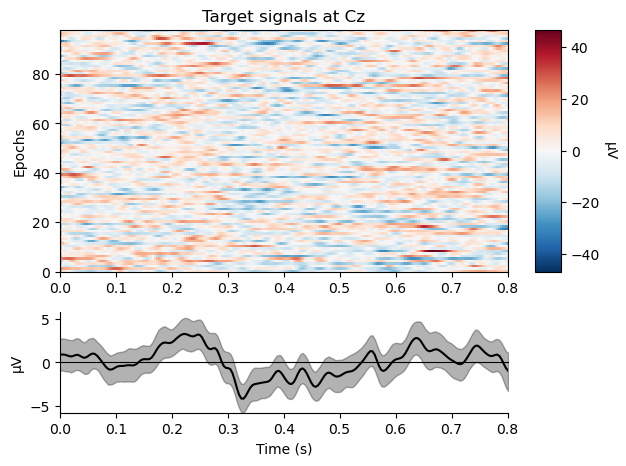

[<Figure size 640x480 with 3 Axes>]

In [33]:
channel_pick = raw_data.ch_names[5] # EEG_CZ
# Plot target signals at a specific channel
epochs['target'].plot_image(picks=channel_pick,
                            title='Target signals at '+channel_pick[4:])

Not setting metadata
735 matching events found
No baseline correction applied
0 projection items activated


/var/folders/q5/lmwck4v56_bbv_rr256g0bpr0000gn/T/ipykernel_8389/3887258469.py:2: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs['non_target'].plot_image(picks=channel_pick,


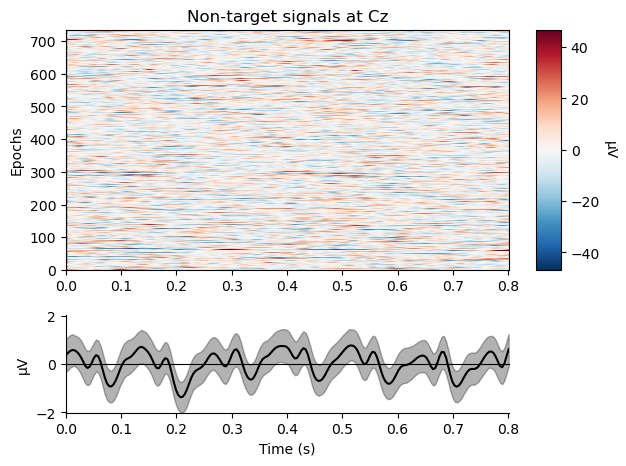

[<Figure size 640x480 with 3 Axes>]

In [34]:
# Plot non-target signals at a specific channel
epochs['non_target'].plot_image(picks=channel_pick,
                                title='Non-target signals at '+channel_pick[4:])

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


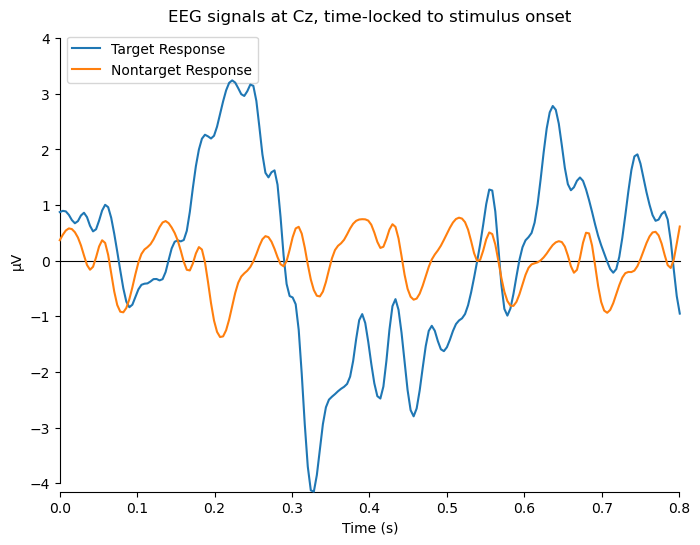

[<Figure size 800x600 with 1 Axes>]

In [40]:
# Average target and nontarget signals
erp_target = epochs['target'].average()
erp_nontarget = epochs['non_target'].average()
figure_title = 'EEG signals at '+channel_pick[4:]+', time-locked to stimulus onset'
mne.viz.plot_compare_evokeds(evokeds={'Target Response': erp_target,
                                      'Nontarget Response': erp_nontarget},
                             picks=channel_pick,
                             show_sensors=False,
                             title=figure_title)

In [41]:
core_channel_names = ('EEG_Fz',  'EEG_Cz',  'EEG_P3', 'EEG_Pz', 'EEG_P4',
                      'EEG_PO7', 'EEG_PO8', 'EEG_Oz')
core_eeg_channels = mne.pick_channels(raw_data.info['ch_names'],
                                      core_channel_names)
core_epochs = mne.Epochs(raw=raw_data, events=stim_events, tmin=t_min, tmax=t_max,
                         event_id=event_dict, preload=True, baseline=None,
                         proj=False, picks=core_eeg_channels)

Not setting metadata
833 matching events found
No baseline correction applied
Using data from preloaded Raw for 833 events and 206 original time points ...
0 bad epochs dropped


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
combining channels using "mean"
combining channels using "mean"


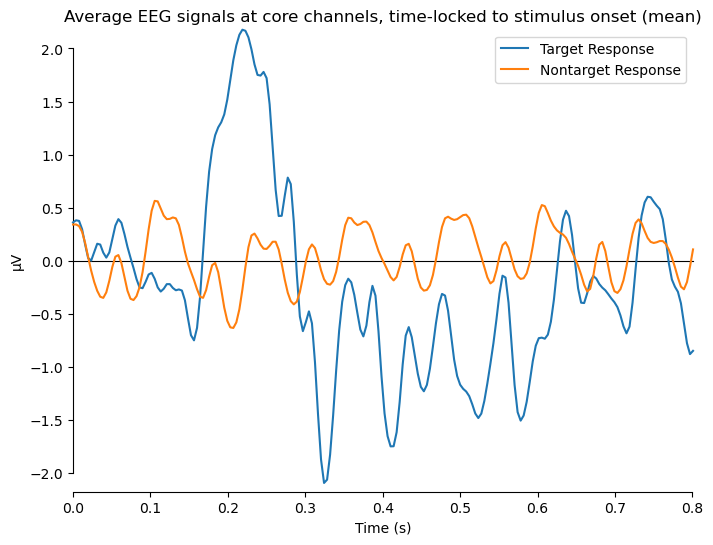

[<Figure size 800x600 with 1 Axes>]

In [46]:
# Average target and nontarget signals
erp_target = core_epochs['target'].average()
erp_nontarget = core_epochs['non_target'].average()
figure_title = 'Average EEG signals at core channels, time-locked to stimulus onset'
mne.viz.plot_compare_evokeds(evokeds={'Target Response': erp_target,
                                      'Nontarget Response': erp_nontarget},
                             combine='mean',
                             show_sensors=False,
                             title=figure_title,
                             legend=1)